# VGG16 Network

In [1]:
import torch
import torch.nn as nn

class VGG16Scratch(nn.Module):
    def __init__(self, num_classes=1000):  # must match for loading weights
        super(VGG16Scratch, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),  # must be 1000 to match pretrained
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


# Print Parameters Per Layer

In [2]:
model = VGG16Scratch(num_classes=20)
print("Trainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel()} parameters")

Trainable parameters:
features.0.weight: 1728 parameters
features.0.bias: 64 parameters
features.2.weight: 36864 parameters
features.2.bias: 64 parameters
features.5.weight: 73728 parameters
features.5.bias: 128 parameters
features.7.weight: 147456 parameters
features.7.bias: 128 parameters
features.10.weight: 294912 parameters
features.10.bias: 256 parameters
features.12.weight: 589824 parameters
features.12.bias: 256 parameters
features.14.weight: 589824 parameters
features.14.bias: 256 parameters
features.17.weight: 1179648 parameters
features.17.bias: 512 parameters
features.19.weight: 2359296 parameters
features.19.bias: 512 parameters
features.21.weight: 2359296 parameters
features.21.bias: 512 parameters
features.24.weight: 2359296 parameters
features.24.bias: 512 parameters
features.26.weight: 2359296 parameters
features.26.bias: 512 parameters
features.28.weight: 2359296 parameters
features.28.bias: 512 parameters
classifier.0.weight: 102760448 parameters
classifier.0.bias: 40

# Visual Summary

In [3]:
pip install torchsummary

In [4]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # make sure model is on GPU

summary(model, input_size=(3, 224, 224), device="cuda")  # tell summary to use cuda too


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# Load Pretrained Weights

In [5]:
import torchvision.models as models

model = VGG16Scratch(num_classes=1000)
pretrained = models.vgg16(pretrained=True)
model.load_state_dict(pretrained.state_dict(), strict=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 185MB/s]


<All keys matched successfully>

In [6]:
#Replace Output Layer for 20 Classes
model.classifier[-1] = nn.Linear(4096, 20)

# Script to structure training data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#unzip the files

import zipfile
import os

# Unzip train
train_zip = "/content/drive/MyDrive/DATA255_Assignmnet3/imagenet_train.zip"
val_zip = "/content/drive/MyDrive/DATA255_Assignmnet3/imagenet_val.zip"

with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/train")

with zipfile.ZipFile(val_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/val")


In [9]:
import os
import shutil

val_txt = "/content/drive/MyDrive/DATA255_Assignmnet3/imagenet_val.txt"  # your val mapping file
val_input_folder = "/content/val/imagenet_val20"  # where flat JPEGs are
val_output_folder = "/content/val/imagenet_val20_structured"  # target structured folder

os.makedirs(val_output_folder, exist_ok=True)

with open(val_txt, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) < 2:
            continue
        filename, class_id = parts[0], parts[1]

        class_folder = os.path.join(val_output_folder, class_id)
        os.makedirs(class_folder, exist_ok=True)

        src = os.path.join(val_input_folder, filename)
        dst = os.path.join(class_folder, filename)

        if os.path.exists(src):
            shutil.move(src, dst)
        else:
            print(f"⚠️ Missing: {filename}")


# Data Augmentation and Normalization

In [10]:
import os

val_root = "/content/val/imagenet_val20_structured/"  # Path where val folders 0–19 exist

# Your training class names in the correct order
train_classes = ['n01737021', 'n02006656', 'n02011460', 'n02013706', 'n02033041',
                 'n02093991', 'n02117135', 'n02279972', 'n02415577', 'n02423022',
                 'n02676566', 'n02808440', 'n03016953', 'n03476684', 'n03721384',
                 'n03804744', 'n03935335', 'n03938244', 'n04252225', 'n04346328']

# Rename folders from '0' → 'n01737021', '1' → 'n02006656', ...
for i in range(20):
    old_name = os.path.join(val_root, str(i))
    new_name = os.path.join(val_root, train_classes[i])
    if os.path.exists(old_name):
        os.rename(old_name, new_name)
        print(f"✅ Renamed {old_name} → {new_name}")
    else:
        print(f"⚠️ Folder not found: {old_name}")

✅ Renamed /content/val/imagenet_val20_structured/0 → /content/val/imagenet_val20_structured/n01737021
✅ Renamed /content/val/imagenet_val20_structured/1 → /content/val/imagenet_val20_structured/n02006656
✅ Renamed /content/val/imagenet_val20_structured/2 → /content/val/imagenet_val20_structured/n02011460
✅ Renamed /content/val/imagenet_val20_structured/3 → /content/val/imagenet_val20_structured/n02013706
✅ Renamed /content/val/imagenet_val20_structured/4 → /content/val/imagenet_val20_structured/n02033041
✅ Renamed /content/val/imagenet_val20_structured/5 → /content/val/imagenet_val20_structured/n02093991
✅ Renamed /content/val/imagenet_val20_structured/6 → /content/val/imagenet_val20_structured/n02117135
✅ Renamed /content/val/imagenet_val20_structured/7 → /content/val/imagenet_val20_structured/n02279972
✅ Renamed /content/val/imagenet_val20_structured/8 → /content/val/imagenet_val20_structured/n02415577
✅ Renamed /content/val/imagenet_val20_structured/9 → /content/val/imagenet_val20_s

In [11]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("/content/train/imagenet_train20a", transform=transform_train)
val_dataset = datasets.ImageFolder("/content/val/imagenet_val20_structured", transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [12]:
print("Number of training images:", len(train_dataset))
print("Number of validation images:", len(val_dataset))

Number of training images: 6000
Number of validation images: 1000


In [13]:
print("Train Classes:", train_dataset.classes)
print("Val Classes:  ", val_dataset.classes)
print("Match?        ", train_dataset.classes == val_dataset.classes)

Train Classes: ['n01737021', 'n02006656', 'n02011460', 'n02013706', 'n02033041', 'n02093991', 'n02117135', 'n02279972', 'n02415577', 'n02423022', 'n02676566', 'n02808440', 'n03016953', 'n03476684', 'n03721384', 'n03804744', 'n03935335', 'n03938244', 'n04252225', 'n04346328']
Val Classes:   ['n01737021', 'n02006656', 'n02011460', 'n02013706', 'n02033041', 'n02093991', 'n02117135', 'n02279972', 'n02415577', 'n02423022', 'n02676566', 'n02808440', 'n03016953', 'n03476684', 'n03721384', 'n03804744', 'n03935335', 'n03938244', 'n04252225', 'n04346328']
Match?         True


# Training the Model

In [14]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

def evaluate(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total


# Run for 5 Epochs

In [17]:
num_epochs = 5
train_acc_list = []
val_acc_list = []
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()

    train_acc = evaluate(train_loader)
    val_acc = evaluate(val_loader)

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vgg16_model.pth")

    print(f"Epoch {epoch+1}: Loss={running_loss:.4f}, Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")

Epoch 1: Loss=119.1468, Train Acc=93.78%, Val Acc=89.30%
Epoch 2: Loss=56.7911, Train Acc=95.32%, Val Acc=89.00%
Epoch 3: Loss=23.1895, Train Acc=98.30%, Val Acc=92.40%
Epoch 4: Loss=16.1399, Train Acc=97.67%, Val Acc=91.20%
Epoch 5: Loss=7.9856, Train Acc=99.47%, Val Acc=93.30%


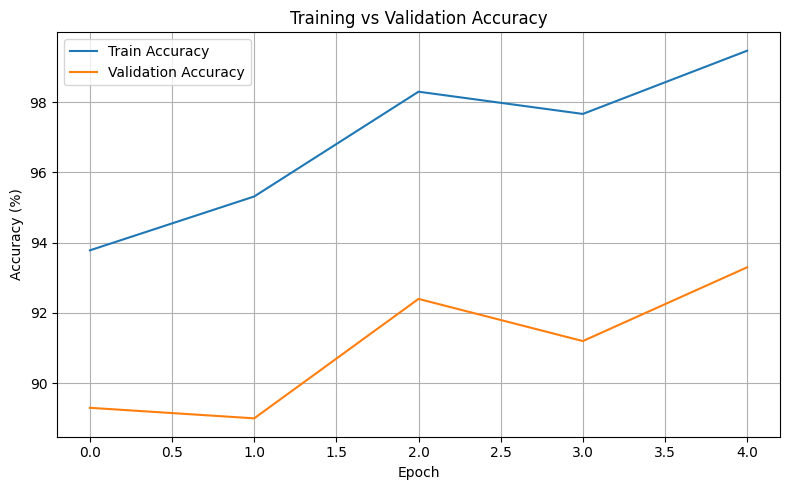

In [19]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# GPU Memory Calculation

In [20]:
import torch

# Reset memory stats and empty cache before measurement
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)

# Forward Pass Only

In [21]:
# Get one batch
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)

# Forward pass (no gradients)
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)

with torch.no_grad():
    outputs = model(images)

forward_memory = torch.cuda.max_memory_allocated(device) / 1024**2  # in MB
print(f" Peak GPU memory (Forward Pass): {forward_memory:.2f} MB")

 Peak GPU memory (Forward Pass): 4645.54 MB


# Forward + Backward Pass

In [22]:
# With gradients this time
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats(device)

outputs = model(images)
loss = criterion(outputs, labels)
loss.backward()

backward_memory = torch.cuda.max_memory_allocated(device) / 1024**2  # in MB
print(f"Peak GPU memory (Forward + Backward Pass): {backward_memory:.2f} MB")


Peak GPU memory (Forward + Backward Pass): 5443.29 MB
